In [1]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

data = """

WITH base AS (
    SELECT 
        ROUND(travel_time_distance_km, 0) AS delivery_distance,
        delivery_costs_eur,
        platform_order_code,
        delivery_fee_eur,
        dps_delivery_fee_eur,
        revenue_eur
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders`
    WHERE created_date >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY)), INTERVAL 4 WEEK)
      AND created_date < DATE_TRUNC(CURRENT_DATE(), WEEK(MONDAY))
      AND is_own_delivery
      AND is_sent
      AND entity_id = 'TB_OM'
      AND city_name IN ('Jalan','Ibri','Khaburah','Rustaq','Ibra','Bahla','Sinaw','Duqm')
      AND zone_name IS NOT NULL
      AND vendor_price_scheme_type = "Automatic scheme"
      AND delivery_costs_local IS NOT NULL
      AND delivery_fee_local IS NOT NULL
      AND commission_local IS NOT NULL
      AND travel_time_distance_km < 16
),
distinct_distances AS (
    SELECT DISTINCT delivery_distance
    FROM base
),
-- Use NTILE to split distances into 3 groups. 
-- NTILE(3) will produce three buckets: 1, 2, and 3. 
-- We'll then use the max of the first and second buckets to get the quantile cutoffs.
distance_buckets AS (
    SELECT 
        delivery_distance,
        NTILE(3) OVER (ORDER BY delivery_distance) AS dist_bucket
    FROM distinct_distances
),
quantiles AS (
    SELECT 
        MAX(CASE WHEN dist_bucket = 1 THEN delivery_distance END) AS q1, -- upper bound of shortest third
        MAX(CASE WHEN dist_bucket = 2 THEN delivery_distance END) AS q2  -- upper bound of medium third
    FROM distance_buckets
)

SELECT
    CASE 
        WHEN b.delivery_distance <= q.q1 THEN 'short'
        WHEN b.delivery_distance <= q.q2 THEN 'medium'
        ELSE 'long'
    END AS distance_bucket,
    SUM(b.delivery_costs_eur) / COUNT(DISTINCT b.platform_order_code) AS delivery_cost_per_order,
    SUM(b.delivery_fee_eur) / COUNT(DISTINCT b.platform_order_code) AS delivery_fee_per_order,
    SUM(b.dps_delivery_fee_eur) / COUNT(DISTINCT b.platform_order_code) AS dps_delivery_fee_per_order,
    COUNT(DISTINCT b.platform_order_code) AS total_orders,
    SUM(b.revenue_eur) AS total_revenue,
    sum(b.delivery_costs_eur) AS total_costs,
FROM base b
CROSS JOIN quantiles q
GROUP BY 1
ORDER BY 1;

"""

In [4]:
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

test_df = client.query(data).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Optimal flat fee: 0.7876530632341077
Original total orders: 79519.0 New total orders: 78804.99203687317
Original profit: -216113.52765087545 New profit: -216310.26942291588


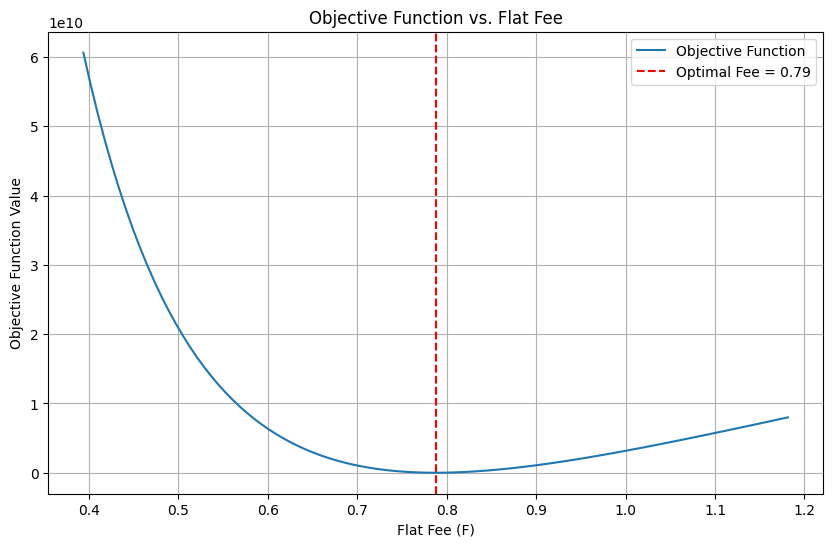

In [29]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

test_df[['delivery_cost_per_order','delivery_fee_per_order','dps_delivery_fee_per_order','total_orders','total_revenue','total_costs']] = test_df[['delivery_cost_per_order','delivery_fee_per_order','dps_delivery_fee_per_order','total_orders','total_revenue','total_costs']].astype(float)

Q_S = test_df[test_df['distance_bucket'] == 'short']['total_orders'].iloc[0]
Q_M = test_df[test_df['distance_bucket'] == 'medium']['total_orders'].iloc[0]
Q_L = test_df[test_df['distance_bucket'] == 'long']['total_orders'].iloc[0]

P_S = test_df[test_df['distance_bucket'] == 'short']['dps_delivery_fee_per_order'].iloc[0]
P_M = test_df[test_df['distance_bucket'] == 'medium']['dps_delivery_fee_per_order'].iloc[0]
P_L = test_df[test_df['distance_bucket'] == 'long']['dps_delivery_fee_per_order'].iloc[0]

C_S = test_df[test_df['distance_bucket'] == 'short']['delivery_cost_per_order'].iloc[0]
C_M = test_df[test_df['distance_bucket'] == 'medium']['delivery_cost_per_order'].iloc[0]
C_L = test_df[test_df['distance_bucket'] == 'long']['delivery_cost_per_order'].iloc[0]

# Elasticities
E_S = -0.9
E_M = -0.8
E_L = -0.7

# Weights
w_Q = 1.0
w_pi = 1.0

# Baseline
Q_orig = Q_S + Q_M + Q_L
profit_orig = (Q_S * (P_S - C_S) +
               Q_M * (P_M - C_M) +
               Q_L * (P_L - C_L))

# Objective function
def objective(F):
    Q_S_new = Q_S * (F / P_S)**E_S
    Q_M_new = Q_M * (F / P_M)**E_M
    Q_L_new = Q_L * (F / P_L)**E_L
    
    Q_new = Q_S_new + Q_M_new + Q_L_new
    profit_new = (Q_S_new * (F - C_S) +
                  Q_M_new * (F - C_M) +
                  Q_L_new * (F - C_L))
    
    orders_diff = (Q_new - Q_orig)**2
    profit_diff = (profit_new - profit_orig)**2
    return w_Q * orders_diff + w_pi * profit_diff

# Initial Guess
F_init = (Q_S * P_S + Q_M * P_M + Q_L * P_L) / Q_orig

# Optimization
result = minimize(objective, F_init, bounds=[(0.01, None)])  # F > 0.01
if result.success:
    F_opt = result.x[0]
    print("Optimal flat fee:", F_opt)
    # Check results
    Q_S_new = Q_S * (F_opt / P_S)**E_S
    Q_M_new = Q_M * (F_opt / P_M)**E_M
    Q_L_new = Q_L * (F_opt / P_L)**E_L
    Q_new = Q_S_new + Q_M_new + Q_L_new
    profit_new = (Q_S_new * (F_opt - C_S) +
                  Q_M_new * (F_opt - C_M) +
                  Q_L_new * (F_opt - C_L))
    
    print("Original total orders:", Q_orig, "New total orders:", Q_new)
    print("Original profit:", profit_orig, "New profit:", profit_new)
else:
    print("Optimization failed:", result.message)

# ---------------------------
# Plot the Objective Function
# ---------------------------
# Let's pick a range around the optimal fee to visualize
F_min = max(0.01, F_opt * 0.5) if result.success else 0.01
F_max = F_opt * 1.5 if result.success else (F_init * 2)
F_values = np.linspace(F_min, F_max, 100)

objective_values = [objective(f) for f in F_values]

plt.figure(figsize=(10, 6))
plt.plot(F_values, objective_values, label='Objective Function')
if result.success:
    plt.axvline(F_opt, color='red', linestyle='--', label=f'Optimal Fee = {F_opt:.2f}')
plt.title('Objective Function vs. Flat Fee')
plt.xlabel('Flat Fee (F)')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()
